<a href="https://colab.research.google.com/github/jessica8403/TIL/blob/master/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow_hub as hub
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [100]:
directory_train = "/content/drive/MyDrive/멀티캠퍼스/data/train/"
directory_test = "/content/drive/MyDrive/멀티캠퍼스/data/test/"

In [91]:
def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         validation_split=validation_split)
    return image_generator

In [111]:
image_gen_train = get_ImageDataGenerator(validation_split=0.2)
image_gen_test = get_ImageDataGenerator(validation_split=None)


In [109]:
def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, 
                                                               batch_size=32, 
                                                               class_mode='categorical', 
                                                               target_size=(299,299), 
                                                               subset=train_valid,seed=seed)   
                                                         
    return train_generator

In [94]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [98]:
image_gen_test = get_ImageDataGenerator(validation_split=None)


In [99]:
test_generator = get_generator(image_gen_test, directory_test)

Found 0 images belonging to 0 classes.


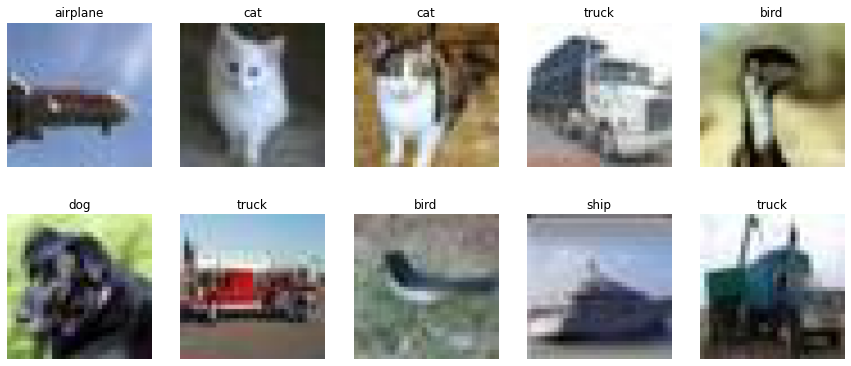

In [9]:
target_labels = next(os.walk(directory_train))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [10]:
def get_benchmark_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output = Dense(target_labels.shape[0], activation='softmax')(h)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

In [11]:
benchmark_model = get_benchmark_model((299, 299, 3))
benchmark_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 299, 299, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 149, 149, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 149, 149, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                         

In [12]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen, 
                        callbacks=[earlystopping])
    
    return history

In [13]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training')
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [16]:
history_benchmark = train_model(benchmark_model, train_generator, validation_generator, 10)

Epoch 1/10
 165/1250 [==>...........................] - ETA: 2:49:49 - loss: 2.1423 - accuracy: 0.2114

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_benchmark.history['accuracy'])
plt.plot(history_benchmark.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
test_steps = test_generator.n // test_generator.batch_size
benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset:')
print("Loss: {}".format(benchmark_test_loss))
print("Accuracy: {}".format(benchmark_test_acc))

Xception 

In [17]:
feature_extractor = tf.keras.applications.Xception(weights="imagenet")

91897856/91884032 [==============================] - 0s 0us/step


In [18]:
feature_extractor.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [19]:
def remove_head(feature_extractor_model):
    model_input = feature_extractor_model.input
    output = feature_extractor_model.get_layer(name='avg_pool').output
    model = tf.keras.Model(inputs=model_input, outputs=output)
    return model

In [20]:
feature_extractor = remove_head(feature_extractor)
feature_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [21]:
def add_new_classifier_head(feature_extractor_model):
    model = Sequential([
        feature_extractor_model,
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(target_labels.shape[0], activation='softmax')
    ])
    
    return model   

In [22]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 21,125,042
Trainable params: 21,070,514
Non-trainable params: 54,528
_________________________________________________________________


In [23]:
def freeze_pretrained_weights(model):
    model.get_layer(name='model_1').trainable=False
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [24]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 21,125,042
Trainable params: 263,562
Non-trainable params: 20,861,480
_________________________________________________________________


In [25]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen)
    
    return history

In [26]:
history_frozen_new_model = train_model(frozen_new_model, train_generator, validation_generator, 10)

Epoch 1/10
1250/1250 [==============================] - 11820s 9s/step - loss: 0.9148 - accuracy: 0.6892 - val_loss: 0.7208 - val_accuracy: 0.7481
Epoch 2/10
1250/1250 [==============================] - 221s 176ms/step - loss: 0.7521 - accuracy: 0.7423 - val_loss: 0.6682 - val_accuracy: 0.7690
Epoch 3/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.7007 - accuracy: 0.7588 - val_loss: 0.6551 - val_accuracy: 0.7682
Epoch 4/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.6622 - accuracy: 0.7692 - val_loss: 0.6544 - val_accuracy: 0.7725
Epoch 5/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.6320 - accuracy: 0.7790 - val_loss: 0.6546 - val_accuracy: 0.7693
Epoch 6/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.6115 - accuracy: 0.7883 - val_loss: 0.6593 - val_accuracy: 0.7733
Epoch 7/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.5898 - accuracy: 0.7929 - val_l

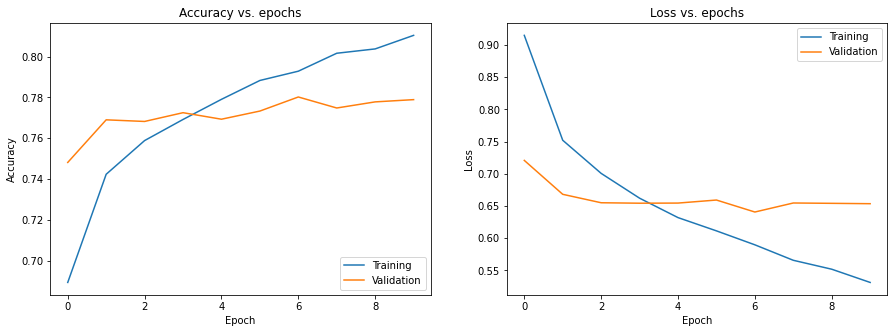

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_new_model.history['accuracy'])
plt.plot(history_frozen_new_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [101]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(new_model_test_loss))
print("Accuracy: {}".format(new_model_test_acc))

Found 0 images belonging to 0 classes.


NameError: ignored

In [50]:
new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]
new_model_train_acc = history_frozen_new_model.history['accuracy'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_accuracy'][-1]

In [102]:
comparison = pd.DataFrame([['Training loss',  new_model_train_loss],
                          ['Training accuracy', new_model_train_acc],
                          ['Validation loss', new_model_valid_loss],
                          ['Validation accuracy',  new_model_valid_acc],
                          ['Test loss', new_model_test_loss],
                          ['Test accuracy', new_model_test_acc]],
                           columns=['xception'])
comparison.index=['']*6
comparison

NameError: ignored

In [103]:
test_generator = get_generator(image_gen_test, directory_test, seed=123)
predictions = new_model.predict(test_generator)

Found 0 images belonging to 0 classes.


ValueError: ignored

In [104]:
test_generator = get_generator(image_gen_test, directory_test, seed=123)
batches = []
for i in range(1):
    batches.append(next(test_generator))

batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

Found 0 images belonging to 0 classes.


ValueError: ignored

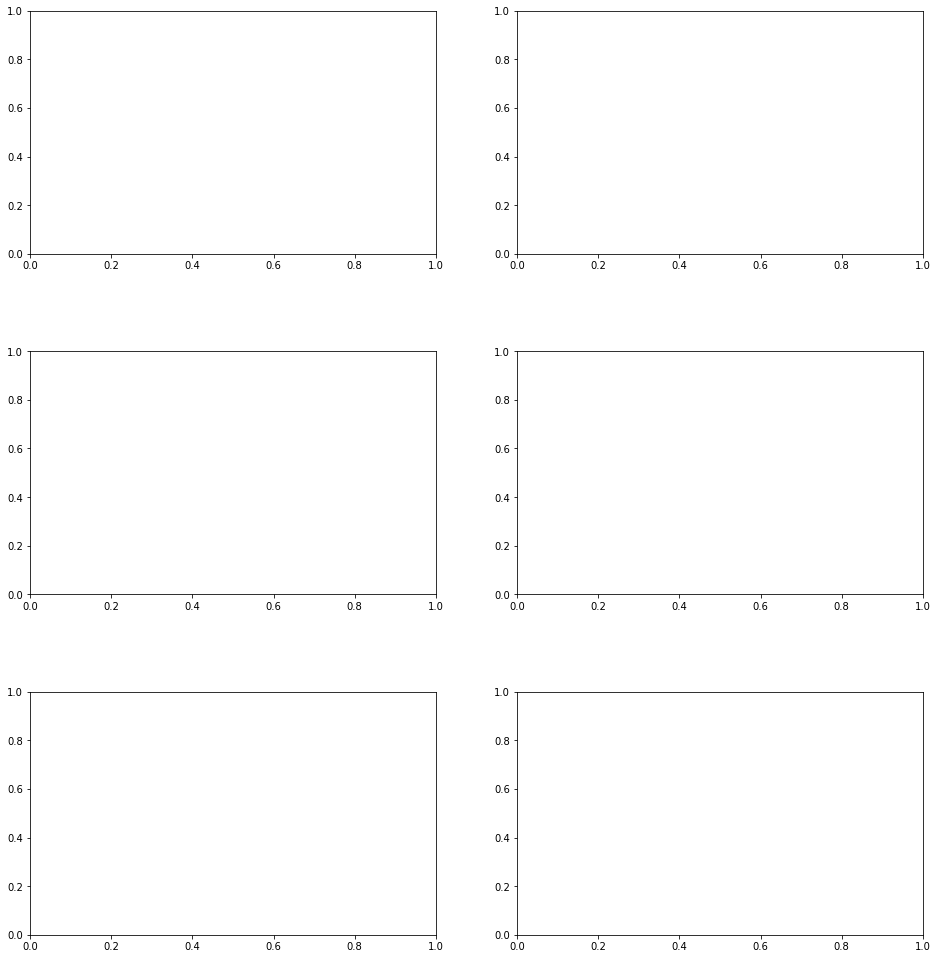

In [105]:
fig, axes = plt.subplots(3, 2, figsize=(16, 17))
fig.subplots_adjust(hspace = 0.4, wspace=0.2)
axes = axes.ravel()

for i in range(3):

    inx = np.random.choice(batch_images.shape[0], 1, replace=False)[0]

    axes[0+i*2].imshow(batch_images[inx])
    axes[0+i*2].get_xaxis().set_visible(False)
    axes[0+i*2].get_yaxis().set_visible(False)
    axes[0+i*2].text(60., -8, target_labels[np.where(batch_labels[inx]==1)[0][0]], 
                    horizontalalignment='center')
    axes[1+i*2].barh(np.arange(len(predictions[inx])),predictions[inx])
    axes[1+i*2].set_yticks(np.arange(len(predictions[inx])))
    axes[1+i*2].set_yticklabels(target_labels)
    axes[1+i*2].set_title(f"Categorical distribution. Model prediction: {target_labels[np.argmax(predictions[inx])]}")
    
plt.show()